In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import operator
import re
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler 
from sklearn.pipeline import _name_estimators
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
#from sklearn.externals import six

# Evaluation
from sklearn import metrics
from sklearn import linear_model, datasets 
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.neighbors import LocalOutlierFactor

# Classifier (machine learning algorithm) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
#from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators

In [3]:
dataset = pd.read_csv('banking_churn.csv', header = 0)

In [4]:
# Tmp data
dataset_tmp = dataset.copy()
dataset_tmp.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Functions

In [59]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'" "; got (vote=%r)" % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal''; got %d weights, %d classifiers' %   
            (len(self.weights), len(self.classifiers)))
        # Use LabelEncoder to ensure class labels start with 0, which is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote
            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis( lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)  for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

# Split Train and Test and check shape 
def SplitDataFrameToTrainAndTest(DataFrame, TrainDataRate, TargetAtt):
    # gets a random TrainDataRate % of the entire set
    training = DataFrame.sample(frac=TrainDataRate, random_state=1)
    # gets the left out portion of the dataset
    testing = DataFrame.loc[~DataFrame.index.isin(training.index)]

    X_train = training.drop(TargetAtt, 1)
    y_train = training[[TargetAtt]]
    X_test = testing.drop(TargetAtt, 1)
    y_test = testing[[TargetAtt]]
    return X_train, y_train, X_test, y_test
    
def PrintTrainTestInformation(X_train, y_train, X_test, y_test):
    print("Train rows and columns : ", X_train.shape)
    print("Test rows and columns : ", X_test.shape)

def DrawJointPlot(DataFrame, XAtt, yAtt, bins = 20):
    sns.set(color_codes=True)
    sns.distplot(data[XAtt], bins=bins);
    df = pd.DataFrame(DataFrame, columns=[XAtt,yAtt])
    df = df.reset_index(drop=True)
    sns.jointplot(x=XAtt, y=yAtt, data=df)
    
def DrawBoxplot2(DataFrame, xAtt, yAtt, hAtt="N/A"):
    plt.figure()
    if(hAtt == "N/A"):
        sns.boxplot(x=xAtt, y=yAtt,  data=DataFrame)
    else:
        sns.boxplot(x=xAtt, y=yAtt,  hue=hAtt,  data=DataFrame)
    plt.show()
    
def DrawBarplot(DataFrame, att):
    Distribution = DataFrame[att].value_counts()
    Distribution = pd.DataFrame({att:Distribution.index, 'Freq':Distribution.values})
    Distribution = Distribution.sort_values(by=att, ascending=True)
    plt.bar(Distribution[att], Distribution["Freq"])
    plt.xticks(Distribution[att])
    plt.ylabel('Frequency')
    plt.title('Barplot of ' + att)
    plt.show()   
    
def DrawCountplot(DataFrame, att, hatt="N/A"):
    if(hatt == "N/A"):
        sns.countplot(x=att, data=DataFrame)
    else:
        sns.countplot(x=att, hue=hatt, data=DataFrame)
    plt.show()
    
def DrawHistogram(DataFrame, att):
    plt.figure()
    DataFrame[att].hist(edgecolor='black', bins=20)
    plt.title(att)
    plt.show()
    
# Detect outlier in each feature
def DetectOutlierByIQR(DataFrame, AttList, Rate = 3.0):
    OutlierIdx = []
    for att in AttList:
        AttData = DataFrame.loc[:, att]
        lowerq = AttData.quantile(0.25)
        upperq = AttData.quantile(0.75)
        IQR = upperq - lowerq
        threshold_upper = (IQR * Rate) + upperq
        threshold_lower = lowerq - (IQR * Rate)
        AttOutlierIdx = set(AttData[AttData.apply(lambda x: x > threshold_upper
                                                    or x < threshold_lower)].index.get_values())
        OutlierIdx = set(OutlierIdx) | AttOutlierIdx
    

    OutlierIdx = list(OutlierIdx)
    OutlierIdx = sorted(OutlierIdx)
    return OutlierIdx
      
# Detect outlier in group features
def DetectOutlierByLOF(DataFrame, AttList, LOFThresh=3.0, neighbors = 10):
    clf = LocalOutlierFactor(n_neighbors=neighbors)
    AttData = DataFrame.loc[:, AttList].values
    y_pred = clf.fit_predict(AttData)
    AttData_scores = -1 * clf.negative_outlier_factor_
    LOFFactorData = pd.DataFrame(AttData_scores, columns=['LOF'])
    LOFFactorData = LOFFactorData.sort_values('LOF', ascending=False)
    LOFFactorData = LOFFactorData.reset_index(drop=False)
    # print(LOFFactorData.loc[0:10, :])
    OutlierThreshold = LOFThresh
    SuspectOutlierData = LOFFactorData[LOFFactorData['LOF'].apply(lambda x: x > OutlierThreshold)]
    OutlierIdx = SuspectOutlierData.loc[:, 'index'].tolist()
    # print("OutlierIdx : " + str(OutlierIdx))
    return OutlierIdx, LOFFactorData
      
def RemoveRowsFromDataFrame(DataFrame, RowIdxList = []):
    DataFrame = DataFrame.drop(RowIdxList)
    DataFrame = DataFrame.reset_index(drop=True)
    return DataFrame

def NaiveBayesLearning(DataTrain, TargetTrain):
    NBModel = GaussianNB()
    NBModel.fit(DataTrain, TargetTrain.values.ravel())
    return NBModel

def NaiveBayesTesting(NBModel,DataTest, TargetTest):
    PredictTest = NBModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    return Accuracy, PredictTest

def LogisticRegressionLearning(DataTrain, TargetTrain):
    logreg = LogisticRegression()
    # Training by Logistic Regression
    logreg.fit(DataTrain, TargetTrain.values.ravel())
    return logreg

def LogisticRegressionTesting(LRModel,DataTest, TargetTest):
    logreg = LRModel
    PredictTest = logreg.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('Logistic regression accuracy: {:.3f}'.format(Accuracy))
    return Accuracy, PredictTest

def RandomForestLearning(DataTrain, TargetTrain):
    rf = RandomForestClassifier()
    rf.fit(DataTrain, TargetTrain.values.ravel())
    return rf

def RandomForestTesting(RFModel,DataTest, TargetTest):
    PredictTest = RFModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(TargetTest, PredictTest)))
    return Accuracy, PredictTest

def SVMLearning(DataTrain, TargetTrain, ClassifierType = " "):
    if(ClassifierType == 'Linear'):
        svc = SVC(kernel="linear", C=0.025)
        # print('SVM Linear processing')
    # Radial basis function kernel
    elif (ClassifierType == 'RBF'):
        svc = SVC(gamma=2, C=1)
        # print('SVM RBF processing')
    else:
        svc = SVC()
        # print('SVM Default processing')
    svc.fit(DataTrain, TargetTrain.values.ravel())
    return svc

def SVMTesting(SVMModel, DataTest, TargetTest):
    PredictTest = SVMModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('Support Vector Machine Accuracy: {:.3f}'.format(accuracy_score(TargetTest, PredictTest)))
    return Accuracy, PredictTest

def KNNLearning(DataTrain, TargetTrain, K = 3):
    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(DataTrain, TargetTrain.values.ravel())
    return neigh

def KNNTesting(KNNModel,DataTest, TargetTest):
    PredictTest = KNNModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('KNN Accuracy: {:.3f}'.format(accuracy_score(TargetTest, PredictTest)))
    return Accuracy, PredictTest

def ANNLearning(DataTrain, TargetTrain):
    ANNModel = MLPClassifier(alpha=1)
    ANNModel.fit(DataTrain, TargetTrain.values.ravel())
    return ANNModel

def ANNTesting (ANNModel, DataTest, TargetTest):
    PredictTest = ANNModel.predict(DataTest)
    Accuracy = accuracy_score(TargetTest, PredictTest)
    # print('Neural Net Accuracy: {:.3f}'.format(Accuracy))
    return Accuracy, PredictTest

# Continuous Data Plot
def ContPlot(df, feature_name, target_name, palettemap, hue_order, feature_scale): 
    df['Counts'] = "" # A trick to skip using an axis (either x or y) on splitting violinplot
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    sns.distplot(df[feature_name], ax=axis0);
    sns.violinplot(x=feature_name, y="Counts", hue=target_name, hue_order=hue_order, data=df,
                   palette=palettemap, split=True, orient='h', ax=axis1)
    axis1.set_xticks(feature_scale)
    plt.show()

# Categorical/Ordinal Data Plot
def CatPlot(df, feature_name, target_name, palettemap): 
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    df[feature_name].value_counts().plot.pie(autopct='%1.1f%%',ax=axis0)
    sns.countplot(x=feature_name, hue=target_name, data=df,
                  palette=palettemap,ax=axis1)
    plt.show()

def MachineLearningModelEvaluate(X_train, y_train, X_test, y_test):
    NBModel = NaiveBayesLearning(X_train, y_train)
    NBAccuracy,NBPredictTest = NaiveBayesTesting(NBModel,X_test, y_test)
    print('Naive Bayes accuracy: {:.3f}'.format(NBAccuracy))

    LRModel = LogisticRegressionLearning(X_train, y_train)
    LRAccuracy,LRPredictTest = LogisticRegressionTesting(LRModel,X_test, y_test)
    print('Logistic Regression accuracy: {:.3f}'.format(LRAccuracy))

    RFModel = RandomForestLearning(X_train, y_train)
    RFAccuracy,RFPredictTest = RandomForestTesting(RFModel,X_test, y_test)
    print('Random Forest accuracy: {:.6f}'.format(RFAccuracy))

    LiSVMModel = SVMLearning(X_train, y_train)
    LiSVMAccuracy,LiSVMPredictTest = SVMTesting(LiSVMModel, X_test, y_test)
    print('Linear SVM accuracy: {:.6f}'.format(LiSVMAccuracy))

    RBFSVMModel = SVMLearning(X_train, y_train, 'RBF')
    RBFSVMAccuracy,RBFSVMPredictTest = SVMTesting(RBFSVMModel, X_test, y_test)
    print('RBF SVM accuracy: {:.6f}'.format(RBFSVMAccuracy))

    KNNModel = KNNLearning(X_train, y_train)
    KNNAccuracy,KNNPredictTest = KNNTesting(KNNModel,X_test, y_test)
    print('K Nearest Neighbor accuracy: {:.6f}'.format(KNNAccuracy))

    ANNModel = ANNLearning(X_train, y_train)
    ANNAccuracy, ANNPredictTest = ANNTesting(ANNModel, X_test, y_test)
    print('ANN accuracy: {:.6f}'.format(ANNAccuracy))
    

In [60]:
# Checking the percentage of missing values in each variable
(dataset.isnull().sum()/len(dataset)*100)

RowNumber          0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

## **Preparation and EDA**

In [61]:
# Split Train and Test and check shape 
data_train, target_train, data_test, target_test = SplitDataFrameToTrainAndTest(dataset, 0.6, 'Exited')
PrintTrainTestInformation(data_train, target_train, data_test, target_test)

Train rows and columns :  (6000, 13)
Test rows and columns :  (4000, 13)


In [62]:
# Check column types
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 9953 to 2374
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        6000 non-null   int64  
 1   CustomerId       6000 non-null   int64  
 2   Surname          6000 non-null   object 
 3   CreditScore      6000 non-null   int64  
 4   Geography        6000 non-null   object 
 5   Gender           6000 non-null   object 
 6   Age              6000 non-null   int64  
 7   Tenure           6000 non-null   int64  
 8   Balance          6000 non-null   float64
 9   NumOfProducts    6000 non-null   int64  
 10  HasCrCard        6000 non-null   int64  
 11  IsActiveMember   6000 non-null   int64  
 12  EstimatedSalary  6000 non-null   float64
dtypes: float64(2), int64(8), object(3)
memory usage: 656.2+ KB


In [63]:
print(" List of unique values in Surname : ")
print(dataset['Surname'].unique())
print(" List of unique values in Geography : ")
print(dataset['Geography'].unique())
print(" List of unique values in Gender : ")
print(dataset['Gender'].unique())

#Special Field
print(" List of unique values in NumOfProducts : ")
print(dataset['NumOfProducts'].unique())

 List of unique values in Surname : 
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
 List of unique values in Geography : 
['France' 'Spain' 'Germany']
 List of unique values in Gender : 
['Female' 'Male']
 List of unique values in NumOfProducts : 
[1 3 2 4]


In [64]:
# Numerical data distribution 
data_train.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,6000.000000,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,5000.534667,1.569090e+07,652.017833,38.801333,5.021667,76069.556590,1.524667,0.702333,0.521833,99470.172248
std,2877.924946,7.201902e+04,96.171969,10.409335,2.888469,62709.267925,0.576582,0.457270,0.499565,57622.657250
min,4.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,2501.250000,1.562812e+07,586.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50343.395000
50%,4995.500000,1.569189e+07,655.000000,37.000000,5.000000,96598.420000,1.000000,1.000000,1.000000,99482.980000
75%,7483.500000,1.575351e+07,718.000000,44.000000,8.000000,127671.927500,2.000000,1.000000,1.000000,149170.417500
max,9999.000000,1.581569e+07,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000


In [65]:
data_train.describe(include=['O'])

,Surname,Geography,Gender
count,6000,6000,6000
unique,2246,3,2
top,Smith,France,Male
freq,23,3026,3259


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc35707e20>,
      dtype=object)

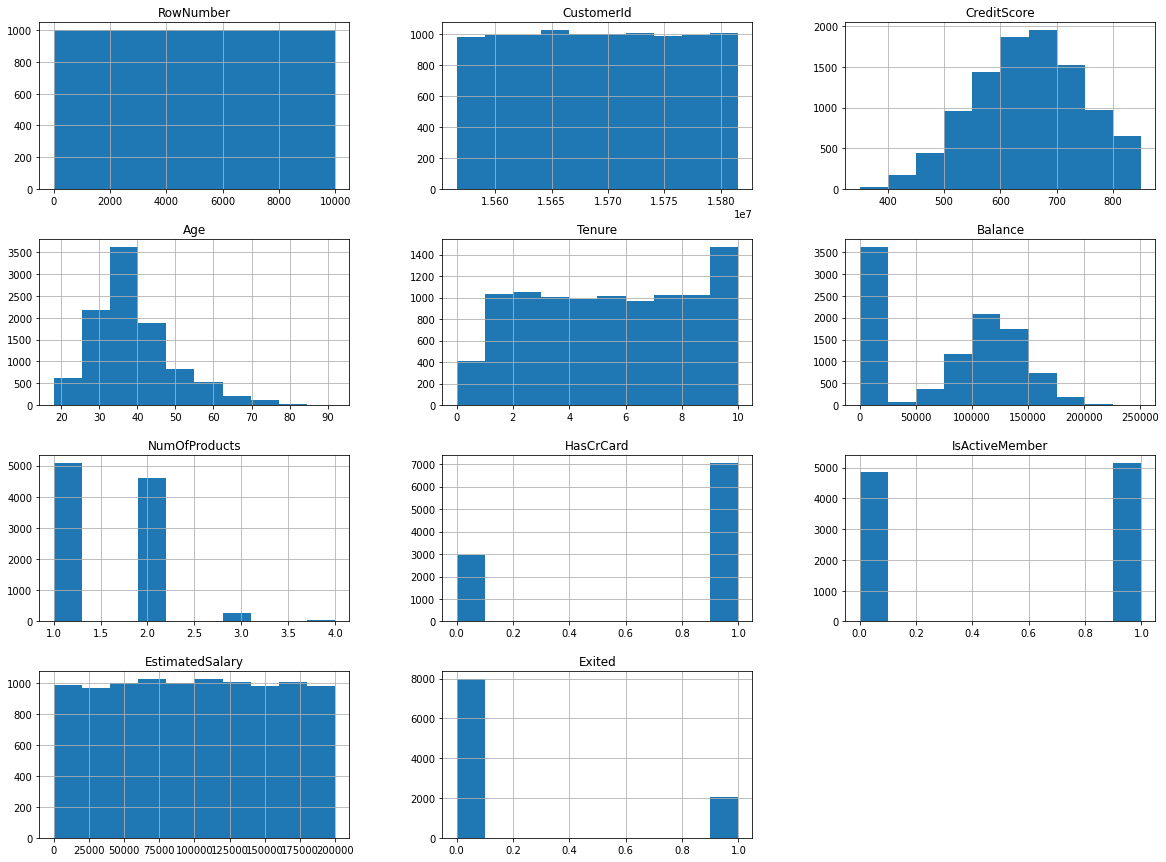

In [66]:
dataset.hist(bins=10, figsize=(20,15))

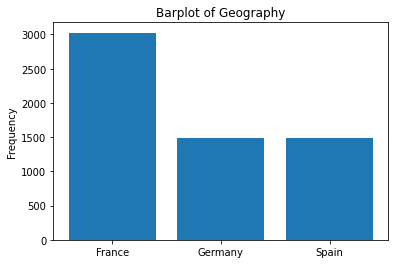

In [67]:
DrawBarplot(data_train, 'Geography')

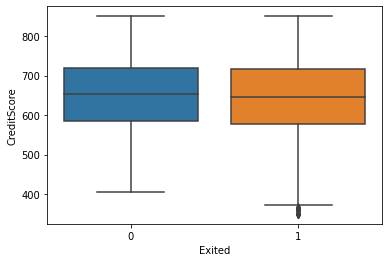

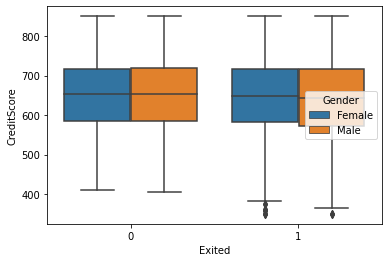

In [68]:
DrawBoxplot2(dataset, xAtt = 'Exited', yAtt='CreditScore')
DrawBoxplot2(dataset, xAtt = 'Exited', yAtt='CreditScore', hAtt='Gender')

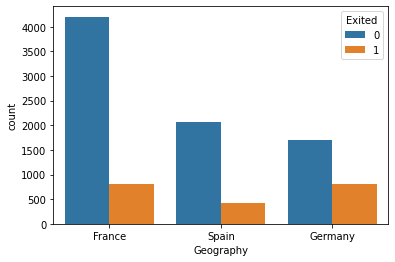

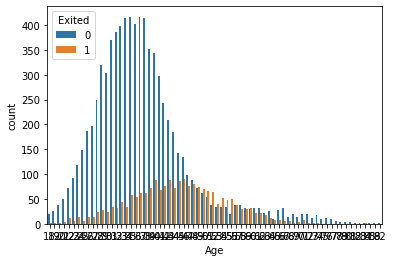

In [69]:
DrawCountplot(dataset, 'Geography', 'Exited')
DrawCountplot(dataset, 'Age', 'Exited')

In [70]:
dataset['CategoricalCreditScore'] = pd.qcut(dataset['CreditScore'], 3)
print (dataset[['CategoricalCreditScore', 'Exited']].groupby(['CategoricalCreditScore'], as_index=False).mean())

  CategoricalCreditScore    Exited
0       (349.999, 608.0]  0.215284
1         (608.0, 695.0]  0.197660
2         (695.0, 850.0]  0.198002


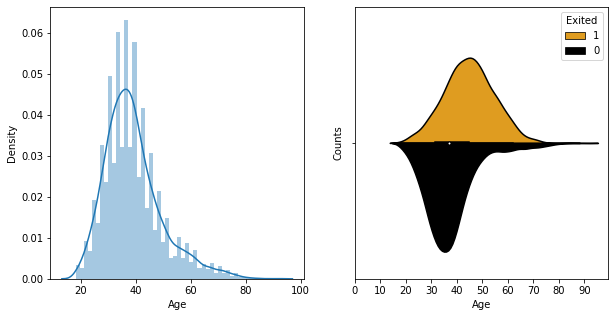

   CategoricalAge    Exited
0  (17.999, 31.0]  0.076307
1    (31.0, 35.0]  0.093206
2    (35.0, 40.0]  0.149603
3    (40.0, 46.0]  0.285967
4    (46.0, 92.0]  0.459416


In [71]:
ContPlot(dataset[['Age','Exited']].copy().dropna(axis=0), 
          'Age', 'Exited', {0: "black", 1: "orange"} , [1, 0], range(0,100,10))

dataset['CategoricalAge'] = pd.qcut(dataset['Age'], 5, duplicates='drop')
print (dataset[['CategoricalAge', 'Exited']].groupby(['CategoricalAge'], as_index=False).mean())

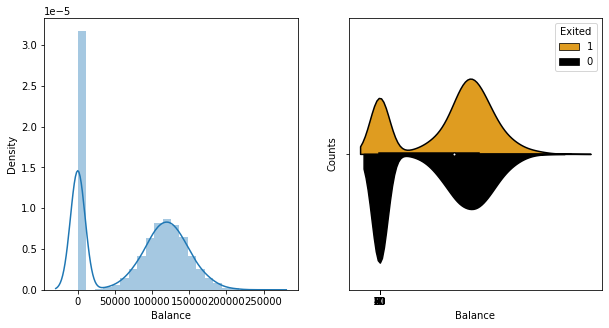

       CategoricalBalance    Exited
0     (-0.001, 118100.59]  0.183441
1  (118100.59, 250898.09]  0.244224


In [72]:
ContPlot(dataset[['Balance','Exited']].copy().dropna(axis=0), 
          'Balance', 'Exited', {0: "black", 1: "orange"} , [1, 0], range(0,100,10))

dataset['CategoricalBalance'] = pd.qcut(dataset['Balance'], 3, duplicates='drop')
print (dataset[['CategoricalBalance', 'Exited']].groupby(['CategoricalBalance'], as_index=False).mean())


In [73]:
data_encoder = dataset.copy()
data_encoder['Geography'] = LabelEncoder().fit_transform(data_encoder['Geography'])
# data_encoder['Surname'] = LabelEncoder().fit_transform(data_encoder['Surname'])
# data_encoder['Gender'] = LabelEncoder().fit_transform(data_encoder['Gender'])
data_encoder = data_encoder.join(pd.get_dummies(data_encoder['Gender'], prefix='Gender'))
data_encoder = data_encoder.drop('Gender', axis=1)

data_encoder.loc[ data_encoder['Balance'] <= 118100.59, 'Balance'] = 0
data_encoder.loc[ data_encoder['Balance'] > 118100.59, 'Balance'] = 1

data_encoder.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CategoricalCreditScore,CategoricalAge,CategoricalBalance,Gender_Female,Gender_Male
0,1,15634602,Hargrave,619,0,42,2,0.0,1,1,1,101348.88,1,"(608.0, 695.0]","(40.0, 46.0]","(-0.001, 118100.59]",1,0
1,2,15647311,Hill,608,2,41,1,0.0,1,0,1,112542.58,0,"(349.999, 608.0]","(40.0, 46.0]","(-0.001, 118100.59]",1,0
2,3,15619304,Onio,502,0,42,8,1.0,3,1,0,113931.57,1,"(349.999, 608.0]","(40.0, 46.0]","(118100.59, 250898.09]",1,0
3,4,15701354,Boni,699,0,39,1,0.0,2,0,0,93826.63,0,"(695.0, 850.0]","(35.0, 40.0]","(-0.001, 118100.59]",1,0
4,5,15737888,Mitchell,850,2,43,2,1.0,1,1,1,79084.10,0,"(695.0, 850.0]","(40.0, 46.0]","(118100.59, 250898.09]",1,0
5,6,15574012,Chu,645,2,44,8,0.0,2,1,0,149756.71,1,"(608.0, 695.0]","(40.0, 46.0]","(-0.001, 118100.59]",0,1
6,7,15592531,Bartlett,822,0,50,7,0.0,2,1,1,10062.80,0,"(695.0, 850.0]","(46.0, 92.0]","(-0.001, 118100.59]",0,1
7,8,15656148,Obinna,376,1,29,4,0.0,4,1,0,119346.88,1,"(349.999, 608.0]","(17.999, 31.0]","(-0.001, 118100.59]",1,0
8,9,15792365,He,501,0,44,4,1.0,2,0,1,74940.50,0,"(349.999, 608.0]","(40.0, 46.0]","(118100.59, 250898.09]",0,1
9,10,15592389,H?,684,0,27,2,1.0,1,1,1,71725.73,0,"(608.0, 695.0]","(17.999, 31.0]","(118100.59, 250898.09]",0,1


In [74]:
AttList = ["RowNumber", "CustomerId", "Surname", "CategoricalCreditScore", "CategoricalAge", "CategoricalBalance"]
data_encoder = data_encoder.drop(AttList, axis=1)
data_encoder.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Female,Gender_Male
0,619,0,42,2,0.0,1,1,1,101348.88,1,1,0
1,608,2,41,1,0.0,1,0,1,112542.58,0,1,0
2,502,0,42,8,1.0,3,1,0,113931.57,1,1,0
3,699,0,39,1,0.0,2,0,0,93826.63,0,1,0
4,850,2,43,2,1.0,1,1,1,79084.10,0,1,0


In [75]:
# Split Train and Test and check shape 
data_train_encoder, target_train_encoder, data_test_encoder, target_test_encoder = SplitDataFrameToTrainAndTest(data_encoder, 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder, target_train_encoder, data_test_encoder, target_test_encoder)

Train rows and columns :  (6000, 11)
Test rows and columns :  (4000, 11)


## **Classification by trainditional models** 

In [76]:
X_train = data_train_encoder
y_train = target_train_encoder
X_test = data_test_encoder
y_test = target_test_encoder

In [77]:
MachineLearningModelEvaluate(X_train, y_train, X_test, y_test)

Naive Bayes accuracy: 0.770
Logistic Regression accuracy: 0.785
Random Forest accuracy: 0.850250
Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250
K Nearest Neighbor accuracy: 0.736250
ANN accuracy: 0.798000


In [78]:
## get the most important variables. 
corr = dataset.corr()**2
corr.Exited.sort_values(ascending=False)

Exited             1.000000
Age                0.081409
IsActiveMember     0.024376
Balance            0.014050
NumOfProducts      0.002287
CreditScore        0.000734
RowNumber          0.000275
Tenure             0.000196
EstimatedSalary    0.000146
HasCrCard          0.000051
CustomerId         0.000039
Name: Exited, dtype: float64

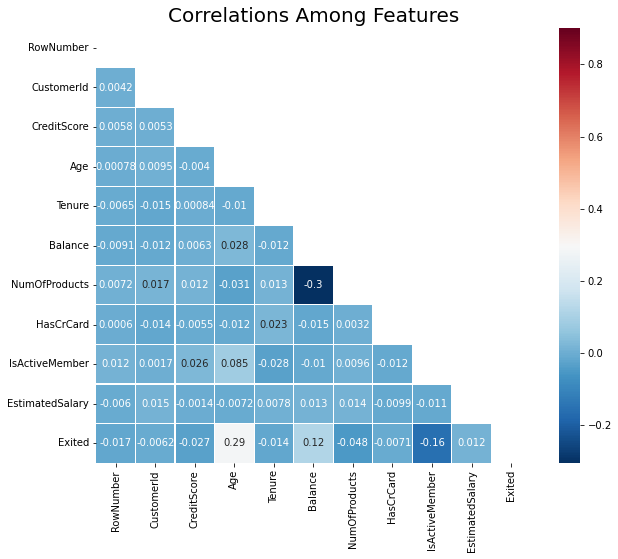

In [79]:
# Heatmeap to see the correlation between features. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(dataset.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# plot
plt.subplots(figsize = (10,8))
sns.heatmap(dataset.corr(), annot=True, mask = mask, cmap = 'RdBu_r', linewidths=0.1, linecolor='white', vmax = .9, square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 20);

   NumOfProducts    Exited
3              4  1.000000
2              3  0.827068
0              1  0.277144
1              2  0.075817


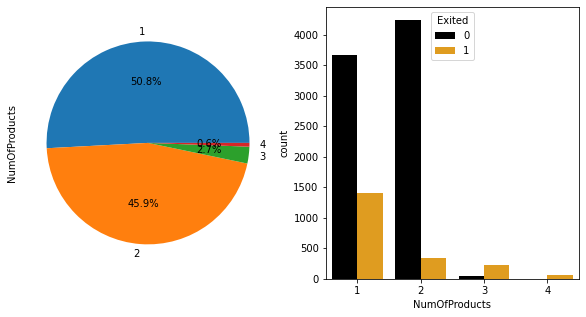

In [80]:
print(dataset[['NumOfProducts', 'Exited']].groupby(['NumOfProducts'], as_index=False).mean().sort_values(by='Exited', ascending=False))
CatPlot(dataset, 'NumOfProducts','Exited', {0: "black", 1: "orange"} )

   IsActiveMember    Exited
0               0  0.268509
1               1  0.142691


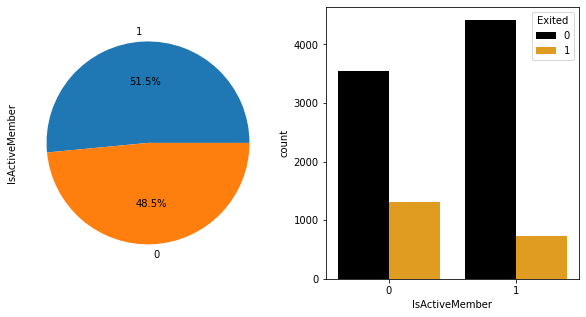

In [81]:
print(dataset[['IsActiveMember', 'Exited']].groupby(['IsActiveMember'], as_index=False).mean().sort_values(by='Exited', ascending=False))
CatPlot(dataset, 'IsActiveMember','Exited', {0: "black", 1: "orange"} )

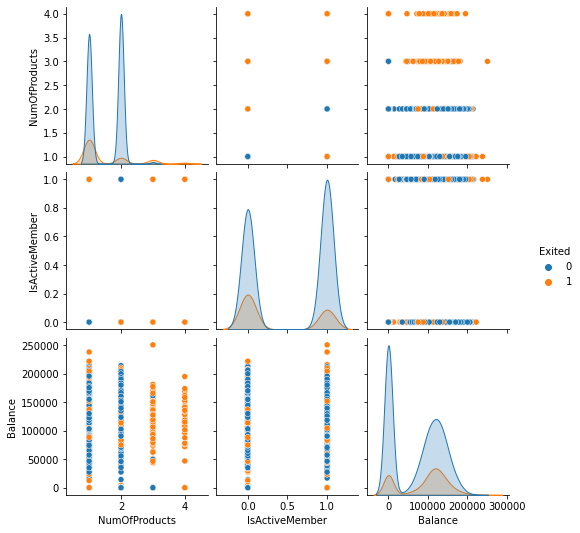

In [82]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
sns.pairplot(dataset, vars=["NumOfProducts", "IsActiveMember", "Balance"], hue="Exited")

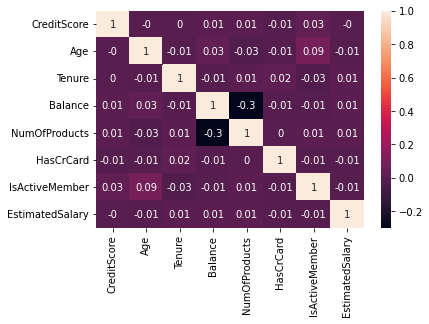

In [83]:
AttList = ["CreditScore",	"Age",	"Tenure",	"Balance",	"NumOfProducts",	"HasCrCard",	"IsActiveMember",	"EstimatedSalary"]
correlation_matrix = dataset[AttList].corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [84]:
data_encoder_feselection = data_encoder.copy()
# AttList = ["Surname", "RowNumber", "CustomerId"]
# data_encoder_feselection = data_encoder_feselection.drop(AttList,  axis=1)
print(data_encoder_feselection.shape)
data_encoder_feselection.head()

(10000, 12)


,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Female,Gender_Male
0,619,0,42,2,0.0,1,1,1,101348.88,1,1,0
1,608,2,41,1,0.0,1,0,1,112542.58,0,1,0
2,502,0,42,8,1.0,3,1,0,113931.57,1,1,0
3,699,0,39,1,0.0,2,0,0,93826.63,0,1,0
4,850,2,43,2,1.0,1,1,1,79084.10,0,1,0


In [85]:
# Split Train and Test and check shape 
data_train_encoder_feselection, target_train_encoder_feselection, data_test_encoder_feselection, target_test_encoder_feselection = SplitDataFrameToTrainAndTest(data_encoder_feselection, 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder_feselection, target_train_encoder_feselection, data_test_encoder_feselection, target_test_encoder_feselection)

Train rows and columns :  (6000, 11)
Test rows and columns :  (4000, 11)


In [86]:
# Retest all traditional classification approaches
X_train = data_train_encoder
y_train = target_train_encoder
X_test = data_test_encoder
y_test = target_test_encoder

MachineLearningModelEvaluate(X_train, y_train, X_test, y_test)

Naive Bayes accuracy: 0.770
Logistic Regression accuracy: 0.785
Random Forest accuracy: 0.853250
Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250
K Nearest Neighbor accuracy: 0.736250
ANN accuracy: 0.797750


In [87]:
# Retest all traditional classification approaches
X_train = data_train_encoder_feselection
y_train = target_train_encoder_feselection
X_test = data_test_encoder_feselection
y_test = target_test_encoder_feselection

MachineLearningModelEvaluate(X_train, y_train, X_test, y_test)

Naive Bayes accuracy: 0.770
Logistic Regression accuracy: 0.785
Random Forest accuracy: 0.851750
Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250
K Nearest Neighbor accuracy: 0.736250
ANN accuracy: 0.798000


## Feature Importances

(6000, 11)


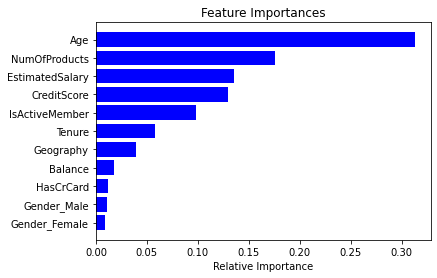

In [88]:
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(data_train_encoder,target_train_encoder.values.ravel())

print(data_train_encoder.shape)
features = data_train_encoder.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-len(features):]  # top features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [89]:
# Get numerical feature importances
feature_list = list(data_train_encoder.columns)
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Age                  Importance: 0.31
Variable: NumOfProducts        Importance: 0.18
Variable: EstimatedSalary      Importance: 0.14
Variable: CreditScore          Importance: 0.13
Variable: IsActiveMember       Importance: 0.1
Variable: Tenure               Importance: 0.06
Variable: Geography            Importance: 0.04
Variable: Balance              Importance: 0.02
Variable: HasCrCard            Importance: 0.01
Variable: Gender_Female        Importance: 0.01
Variable: Gender_Male          Importance: 0.01


In [90]:
# Split Train and Test and check shape 
AttSelection = ["Age", "NumOfProducts", "EstimatedSalary", "CreditScore", "Tenure", "Geography", "Balance",
                "Exited"]

data_train_encoder_feselection02, target_train_encoder_feselection02, data_test_encoder_feselection02, target_test_encoder_feselection02 = SplitDataFrameToTrainAndTest(data_encoder[AttSelection], 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder_feselection02, target_train_encoder_feselection02, data_test_encoder_feselection02, target_test_encoder_feselection02)

Train rows and columns :  (6000, 7)
Test rows and columns :  (4000, 7)


In [91]:
# Retest all traditional classification approaches
X_train = data_train_encoder_feselection02
y_train = target_train_encoder_feselection02
X_test = data_test_encoder_feselection02
y_test = target_test_encoder_feselection02

MachineLearningModelEvaluate(X_train, y_train, X_test, y_test)

Naive Bayes accuracy: 0.767
Logistic Regression accuracy: 0.785
Random Forest accuracy: 0.843500
Linear SVM accuracy: 0.798250
RBF SVM accuracy: 0.798250
K Nearest Neighbor accuracy: 0.736000
ANN accuracy: 0.797000


In [92]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.svm import SVR

# Retest all traditional classification approaches
X_train = data_train_encoder
y_train = target_train_encoder
X_test = data_test_encoder
y_test = target_test_encoder

LRModel = LogisticRegressionLearning(X_train, y_train)
model = LRModel
rfe = RFE(model)
rfe = rfe.fit(X_train, y_train.values.ravel())

feature_list = list(X_train.columns)
RankStatistics = pd.DataFrame(columns=['Attributes', 'Ranking', 'Support'])
for i, att, rank, suppport in zip(range(len(feature_list)), feature_list, rfe.ranking_, rfe.support_):
    RankStatistics.loc[i] = [att, rank, suppport]
RankStatistics = RankStatistics.sort_values('Ranking')

RankStatistics

,Attributes,Ranking,Support
1,Geography,1,True
4,Balance,1,True
5,NumOfProducts,1,True
7,IsActiveMember,1,True
10,Gender_Male,1,True
2,Age,2,False
9,Gender_Female,3,False
3,Tenure,4,False
6,HasCrCard,5,False
0,CreditScore,6,False


In [93]:
# Split Train and Test and check shape 
AttSelection = RankStatistics[(RankStatistics["Support"] == True)]
AttSelection = list(filter(lambda a: a not in ["CustomerId", "Surname"], AttSelection["Attributes"]))
AttSelection = AttSelection + ['Exited']

data_train_encoder_feselection03, target_train_encoder_feselection03, data_test_encoder_feselection03, target_test_encoder_feselection03 = SplitDataFrameToTrainAndTest(data_encoder[AttSelection], 0.6, 'Exited')
PrintTrainTestInformation(data_train_encoder_feselection03, target_train_encoder_feselection03, data_test_encoder_feselection03, target_test_encoder_feselection03)

Train rows and columns :  (6000, 5)
Test rows and columns :  (4000, 5)


In [94]:
# Retest all traditional classification approaches
X_train = data_train_encoder_feselection03
y_train = target_train_encoder_feselection03
X_test = data_test_encoder_feselection03
y_test = target_test_encoder_feselection03

MachineLearningModelEvaluate(X_train, y_train, X_test, y_test)

Naive Bayes accuracy: 0.820
Logistic Regression accuracy: 0.798
Random Forest accuracy: 0.819500
Linear SVM accuracy: 0.821500
RBF SVM accuracy: 0.819500
K Nearest Neighbor accuracy: 0.780000
ANN accuracy: 0.821250


In [95]:
# Feature Reduction: Dimensionality Reduction with PCA.
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

AttRemoved = ["RowNumber", "CustomerId", "Surname", "HasCrCard", "Gender_Male", "Gender_Female"]
DataFrame = data_encoder
hr_vars = DataFrame.columns.values.tolist()
hr_vars = list(filter(lambda a: a not in AttRemoved, hr_vars))
targets = ['Exited']
features = [i for i in hr_vars if i not in targets]

# Separating out the features
x = DataFrame.loc[:, features].values
# Separating out the target
y = DataFrame.loc[:, ['Exited']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

nSelectedFeature = len(hr_vars) - 1
SelectedAttList = []
for i in range(1, nSelectedFeature + 1):
    SelectedAttList.append("principal component" + str(i))


pca = PCA(n_components=nSelectedFeature)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=SelectedAttList)
PCAdf = pd.concat([principalDf, DataFrame[targets]], axis=1)
PCAdf = PCAdf.dropna()
PCAdata = PCAdf

PCAdata.head(10)

,principal component1,principal component2,principal component3,principal component4,principal component5,principal component6,principal component7,principal component8,Exited
0,-0.210853,0.884002,1.446764,0.278925,-0.634165,0.096706,-0.253957,-0.944001,1
1,-0.569838,1.195424,0.047422,0.380679,0.028651,-1.688115,-0.447760,-1.349368,0
2,0.869274,-1.103759,0.016253,1.523084,0.787701,0.617678,0.319225,2.904623,1
3,1.128893,-0.151478,1.081788,-0.534498,-0.756419,-0.618177,1.185436,0.322298,0
4,-1.923635,1.451394,-1.077486,-1.795071,-0.735991,-0.963920,-0.146821,0.122698,0
5,0.847114,-0.370761,-1.909737,0.815389,0.614184,-0.434943,0.884744,-0.210759,1
6,0.937177,1.788649,0.042209,-1.637323,0.347318,1.693827,0.486942,0.326536,0
7,3.409745,-1.006174,0.435076,2.204620,1.414215,-1.814186,-0.327603,2.408140,1
8,-0.565255,0.566436,1.276217,1.057400,0.478299,0.262575,-0.764268,1.755141,0
9,-1.303973,-0.089951,1.253032,-1.072287,-0.924581,-0.059585,-1.356978,0.445756,0


In [96]:
PCAdata_train, PCAtarget_train, PCAdata_test, PCAtarget_test = SplitDataFrameToTrainAndTest(PCAdata, 0.6, 'Exited')
PrintTrainTestInformation(PCAdata_train, PCAtarget_train, PCAdata_test, PCAtarget_test)

Train rows and columns :  (6000, 8)
Test rows and columns :  (4000, 8)


In [97]:
# Retest all traditional classification approaches
X_train = PCAdata_train
y_train = PCAtarget_train
X_test = PCAdata_test
y_test = PCAtarget_test

MachineLearningModelEvaluate(X_train, y_train, X_test, y_test)

Naive Bayes accuracy: 0.827
Logistic Regression accuracy: 0.802
Random Forest accuracy: 0.845250
Linear SVM accuracy: 0.853250
RBF SVM accuracy: 0.810500
K Nearest Neighbor accuracy: 0.817500
ANN accuracy: 0.851500


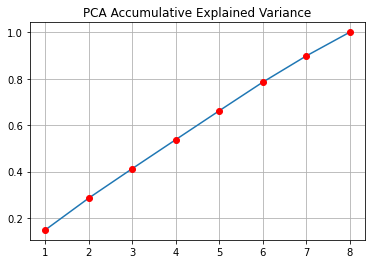

In [98]:
import matplotlib.pyplot as plt

cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] +
                                 cum_explained_var[i - 1])

x_val = range(1, len(cum_explained_var) + 1)
y_val = cum_explained_var

fig = plt.figure()
plt.plot(x_val, y_val)
plt.plot(x_val, y_val, 'or')
plt.title("PCA Accumulative Explained Variance")
plt.xticks(range(1, len(cum_explained_var) + 1))
plt.grid(True)
plt.show()

In [99]:
AttSelection = PCAdata.columns.values.tolist()
AttSelection = AttSelection[:15]
if AttSelection[len(AttSelection)-1] != 'Exited' :
    AttSelection = AttSelection + ['Exited']
print(AttSelection)

PCAdata_train_feReduction, PCAtarget_train_feReduction, PCAdata_test_feReduction, PCAtarget_test_feReduction = SplitDataFrameToTrainAndTest(PCAdata[AttSelection], 0.6, 'Exited')
PrintTrainTestInformation(PCAdata_train_feReduction, PCAtarget_train_feReduction, PCAdata_test_feReduction, PCAtarget_test_feReduction)

['principal component1', 'principal component2', 'principal component3', 'principal component4', 'principal component5', 'principal component6', 'principal component7', 'principal component8', 'Exited']
Train rows and columns :  (6000, 8)
Test rows and columns :  (4000, 8)


In [100]:
# Retest all traditional classification approaches
X_train = PCAdata_train_feReduction
y_train = PCAtarget_train_feReduction
X_test = PCAdata_test_feReduction
y_test = PCAtarget_test_feReduction

MachineLearningModelEvaluate(X_train, y_train, X_test, y_test)

Naive Bayes accuracy: 0.827
Logistic Regression accuracy: 0.802
Random Forest accuracy: 0.845750
Linear SVM accuracy: 0.853250
RBF SVM accuracy: 0.810500
K Nearest Neighbor accuracy: 0.817500
ANN accuracy: 0.850000
